# TuRBO for solving ODEs

### Import dependencies

In [1]:
import sys

sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib

from TuRBO.benchmark.rom import SiROM
from TuRBO.turbo_rei import turbo

### Setup the problem and TuRBO settings

In [2]:
# Smoke test
path_dir = "test"  # path to the output directory
# problems = [
#     "HPA101-0"
# ]  # problem name, see the above list or src/define_problems.py
problem = "SiROM-Temp"
itrials = 1  # run number also used as random seed
ns_init = 30  # number of initial samples for each trust region
ns_max = 1000  # number of maximum function evaluation
ns_max_gp = 40  # number of maximum function evaluation for GP-EI
ns_max_saasbo = 31  # number of maximum function evaluation for SAASBO
verbose = True

# for TuRBO-m-REI
acqf = "EI"  # acquisition function in TuRBO: 'EI' or 'TS'
racqf = "qLogREI"  # region-averaged acquisition function: 'REI', 'qREI', 'EI', 'qEI, 'RUCB', 'UCB', or None (None results in the usual TuRBO)
n_trust_regions = 3  # 1:TuRBO-1, m>1:TuRBO-m
batch_size = 1  # batch size for local seach in TuRBO
n_init_region = ns_init  # number of initial sample points when TuRBO starts with REI

dim = 6
dim_emb = 0
device = "cpu"

if "SiROM" in problem:
    problem = problem.split("-")[1]
    problem = SiROM(problem, dim=dim, noise_std=None, negate=False)

### Run TuRBO

In [3]:
# Run TuRBO
turbo(
    path_dir,
    problem,
    int(ns_init),
    int(ns_max),
    int(dim),
    int(dim_emb),
    int(itrials),
    verbose,
    int(n_init_region),
    int(n_trust_regions),
    int(batch_size),
    acqf,
    racqf,
    device,
)

TuRBO-3-EI-qLogREI-1 1
120) Best value: -3.99e+00, TR: 2, TR length: 8.00e-01
121) Best value: -3.99e+00, TR: 1, TR length: 8.00e-01
122) Best value: -3.99e+00, TR: 0, TR length: 8.00e-01
123) Best value: -3.99e+00, TR: 1, TR length: 8.00e-01
124) Best value: -3.99e+00, TR: 0, TR length: 8.00e-01
125) Best value: -3.99e+00, TR: 2, TR length: 8.00e-01
126) Best value: -3.99e+00, TR: 1, TR length: 8.00e-01
127) Best value: -3.99e+00, TR: 0, TR length: 8.00e-01
128) Best value: -3.99e+00, TR: 0, TR length: 8.00e-01
129) Best value: -3.99e+00, TR: 2, TR length: 8.00e-01
130) Best value: -3.99e+00, TR: 2, TR length: 8.00e-01
131) Best value: -3.99e+00, TR: 2, TR length: 8.00e-01
132) Best value: -3.99e+00, TR: 2, TR length: 8.00e-01
133) Best value: -3.99e+00, TR: 2, TR length: 8.00e-01
134) Best value: -3.99e+00, TR: 0, TR length: 8.00e-01
135) Best value: -3.99e+00, TR: 0, TR length: 8.00e-01
136) Best value: -3.99e+00, TR: 1, TR length: 8.00e-01
137) Best value: -3.99e+00, TR: 1, TR leng

### View the results

In [4]:
solutions = pd.read_csv("Temp/ROM_6D/TuRBO-1-EI-REI-1/solutions1.csv")
solutions = solutions.iloc[:, :7]
opt_parameters = solutions.loc[solutions["f1"].idxmin()]

In [5]:
solutions.loc[solutions["f1"].idxmin()]

x1    0.957465
x2    1.000000
x3    0.180952
x4    0.053969
x5    0.429539
x6    0.096619
f1    2.585335
Name: 209, dtype: float64

In [6]:
X = opt_parameters.iloc[:-1].values.reshape(1, -1)
X

array([[0.9574653 , 1.        , 0.18095173, 0.05396927, 0.42953859,
        0.09661922]])

### Calculate the error for validating the solution from TuRBO

In [7]:
error, candidates = problem.evaluate_true(
    X, kwargs={"scale_parameters": True, "return_candidates": True, "optimize_c": True}
)
error, candidates

(tensor([[-2.5672]], dtype=torch.float64),
 array([[9.57890650e+00, 1.00000000e+01, 1.81033634e-02, 5.40638717e-03,
         4.29595635e+00, 1.86957296e-09, 0.00000000e+00, 1.00000000e+00,
         0.00000000e+00]]))

In [8]:
candidates = candidates.T.squeeze(-1)
candidates.shape

(9,)

### Plot the resultant transients

Temp
--- mass ---
[ 9.5789065  1.        10.       ]
--- k ---
[0.01810336 0.00540639]
--- h ---
[4.29595635e+00 1.86957296e-09]
--- c ---
[0. 1. 0.]


Text(0.5, 1.0, 'Temp Validation - RMSerr: 1.49')

<Figure size 640x480 with 0 Axes>

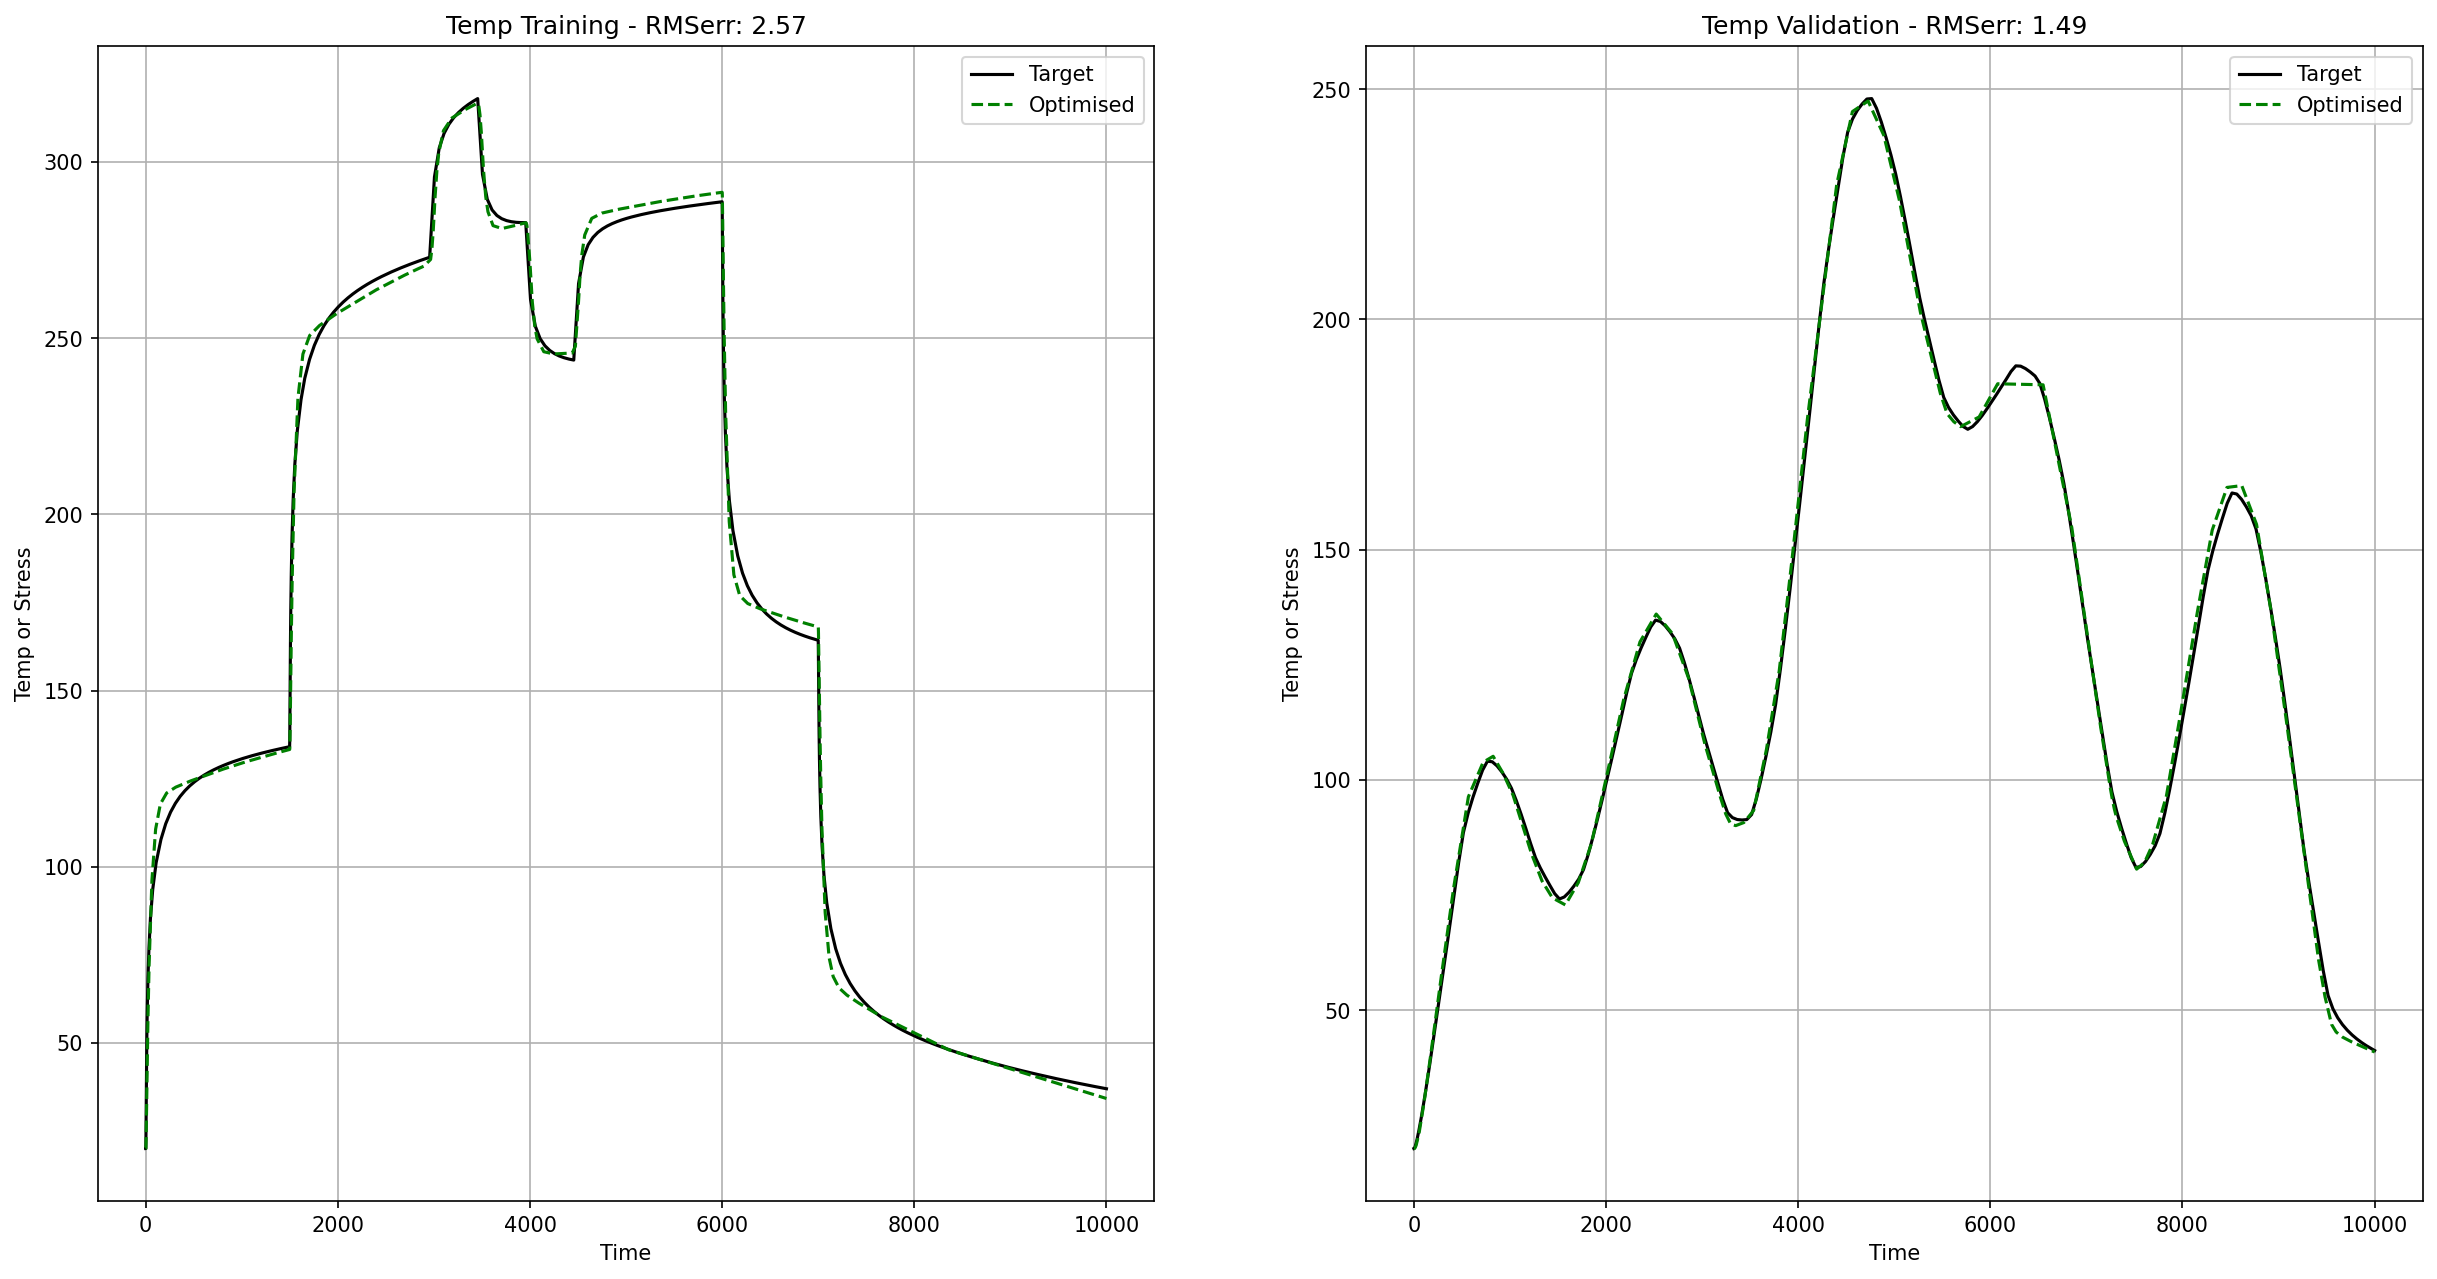

In [9]:
import matplotlib.pyplot as plt

output_name = "n28_Interface_Mid"

mOptArray = np.array([candidates[0], 1.0, candidates[1]])
kOptArray = np.array([candidates[2], candidates[3]])
hOptArray = np.array([candidates[4], candidates[5]])
# cOptArray = np.array([0.0, 1.0, 0.0])
cOptArray = np.array([candidates[6], candidates[7], candidates[8]])


print(problem.rom.output_column)
print("--- mass ---")
print(mOptArray)
print("--- k ---")
print(kOptArray)
print("--- h ---")
print(hOptArray)
print("--- c ---")
print(cOptArray)

# # solve ODE and calculate error
model_parameters = {"m": mOptArray, "k": kOptArray, "h": hOptArray, "c": cOptArray}
optErrTraining, solOpt, c, optYTraining = problem.rom.ErrorCalculation(model_parameters)

# -----------------------------------------------------------------------------
# %%Check against validation case
# -------------------
# solve ODE and calculate error
optErrValidation, solOptVal, c_val, optYValidation = problem.rom.ErrorCalculation(
    model_parameters,
    validation_mode=True,
)
# -----------------------------------------------------------------------------

# %% Plots
# -----------------------------------------------------------------------------
# fit results
plt.figure()
fig, axs = plt.subplots(1, 2)
fig.set_figheight(10), fig.set_figwidth(20), fig.set_dpi(150)
axs[0].plot(
    problem.rom.target_data[0], problem.rom.target_data[1], "k-", label="Target"
)
axs[0].plot(solOpt.t, optYTraining, "g--", label="Optimised")
axs[0].set(xlabel="Time", ylabel="Temp or Stress")
axs[0].legend()
axs[0].grid()
axs[0].set_title(
    problem.rom.output_column + " Training - RMSerr: " + "{:.2f}".format(optErrTraining)
)
# Validation results
validationDataArray = (
    problem.rom.validation_data[["Time", problem.rom.output_column]]
    .to_numpy()
    .transpose()
)
axs[1].plot(validationDataArray[0], validationDataArray[1], "k-", label="Target")
axs[1].plot(solOptVal.t, optYValidation, "g--", label="Optimised")
axs[1].set(xlabel="Time", ylabel="Temp or Stress")
axs[1].legend()
axs[1].grid()
axs[1].set_title(
    problem.rom.output_column
    + " Validation - RMSerr: "
    + "{:.2f}".format(optErrValidation)
)

### Plot the Convergence to the minimum

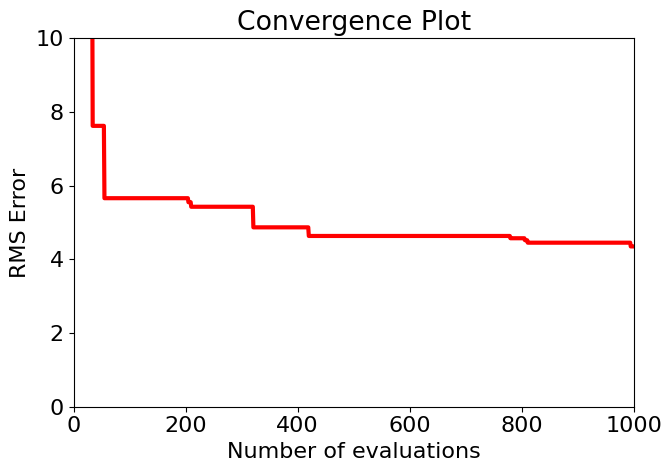

In [10]:
fx = solutions["f1"].values
fig = plt.figure(figsize=(7, 5))
matplotlib.rcParams.update({"font.size": 16})
# plt.plot(fX, "b.", ms=10)  # Plot all evaluated points as blue dots
plt.plot(np.minimum.accumulate(fx), "r", lw=3)  # Plot cumulative minimum as a red line
plt.xlim([0, len(fx)])
plt.ylim([0, 10])
plt.xlabel("Number of evaluations")
plt.ylabel("RMS Error")
plt.title("Convergence Plot")

plt.tight_layout()
plt.show()